# Movie Recommendation System

![title](https://movielens.org/images/site/main-screen.png)

# Abstract

In this notebook, we have analysed the data from movielens dataset and tried to implement recommender system for movies. For this dataset, our main challenge is sparsity of user-movie matrix which means that the number of movie which are rated by user are very less compared to number of movies which are not rated by that same user. As part of data pre-processing, various type of matrix formation has been implemented as per the requirement of all algorithms used in this notebook. we have tried to analyse both neural network and tradition algorithms for recommender system in this notebook. In deep learning, we have implemented Restricted boltzmann machine, Deep Autoencoder, and simple deep neural network to predict the ratings and provide the recommendation based of predicted ratings for the user which has not rated that movie before in the dataset. In traditional algorithms, we have implemented various method of collaborative filtering such as SVD Matrix factorization, SVD++ and Hybrid model. Our analysis is centric towards the results achieved from deep learning algorithms and traditional algorithms by comparing the MSE cost function for all.

## Table of Contents

1. <a href='#acquiring_the_Data'>Acquiring the Data</a>
2. <a href='#loading_the_Data'>Loading the Data</a>
3. <a href='#rbm_model'>The Restricted Boltzmann Machine model</a>
5. <a href='#Dnn_model'> DNN Model</a>
3. <a href='#enc_model'>Deep Autoencoder</a>
4. <a href='#svd'>SVD</a>
5. <a href='#svd++'>SVD ++</a>
6. <a href='#hybrid'>Hybrid Model</a>
3. <a href='#conc'>Conclusion</a>
5. <a href='#contri'>Contribution Statement</a>
5. <a href='#scope'>Scope</a>
3. <a href='#cite'>Citation</a>
3. <a href='#lic'>Licence</a>

<a id='acquiring_the_Data'></a>
## Acquiring the Data

To start, we need to download the data we are going to use for our system. The datasets we are going to use were acquired by [MovieLens](http://files.grouplens.org/datasets/movielens/) and contain movies, users and movie ratings by these users.

With the datasets in place, let's now import the necessary libraries.

In [204]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import mean_squared_error as MSE,mean_absolute_error
from tabulate import tabulate
from sklearn.model_selection import train_test_split

<a id='loading_the_Data'></a>
## Loading the Data

Let's begin by loading in our data with Pandas. The .dat files containing our data are similar to CSV files, but instead of using the ',' (comma) character to separate entries, it uses '::' (two colons) characters instead. To let Pandas know that it should separate data points at every '::', we have to specify the sep='::' parameter when calling the function.

Additionally, we also pass it the header=None parameter due to the fact that our files don't contain any headers.

Let's start with the movies.dat file and take a look at its structure:

In [214]:
#Loading in the movies dataset
movies_df = pd.read_csv('../ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


We can do the same for the ratings.dat file:

In [215]:
# Loading the ratings dataset
ratings_df = pd.read_csv('../ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


So our movies_df variable contains a dataframe that stores a movie's unique ID number, title and genres, while our ratings_df variable stores a unique User ID number, a movie's ID that the user has watched, the user's rating to said movie and when the user rated that movie.

Let's now rename the columns in these dataframes so we can better convey their data more intuitively:

In [216]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


And our final ratings_df:

In [217]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<a id='rbm_model'></a>
## The Restricted Boltzmann Machine model

![title](https://image.slidesharecdn.com/ywcc5eqte2shgzp7cj0w-signature-d9671bf7a659ac86862f44fb333a532bc81113779840cd708cb67b6aff0ce796-poli-180817162756/95/deep-learning-az-boltzmann-machines-module-5-21-638.jpg?cb=1534525031)

The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of movies in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1, where 0 meaning that a user has not watched that movie and the closer the value is to 1, the more the user likes the movie that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset.
After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for movies that user hasn't watched, which is exactly what we can use to recommend movies!

We will now begin to format our dataset to follow the model's expected input.

### Formatting the Data
First let's see how many movies we have and see if the movie ID's correspond with that value:

In [6]:
len(movies_df)

3883

Now, we can start formatting the data into input for the RBM. We're going to store the normalized users ratings into as a matrix of user-rating called trX, and normalize the values.

In [148]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
UserID,,,,,,,,,,,,,,,,,,,,,
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
user_rating_df[user_rating_df.index==215]

MovieID,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
UserID,,,,,,,,,,,,,,,,,,,,,
215,NaN,NaN,5.0,3.0,NaN,NaN,4.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets normalize it now:

In [151]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [153]:
trX[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0., 0., 1., ..., 0., 0., 0.])

### Setting the Model's Parameters

Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to 20. You can freely set this value to any number you want since each neuron in the hidden layer will end up learning a feature.

In [9]:
# Number of hidden nodes
hiddenNodes = 20
# Number of Visible nodes
visibleNodes =  len(user_rating_df.columns)
#Number of unique movies
visibleBias = tf.placeholder("float", [visibleNodes])
#Number of features we're going to learn
hiddenBias = tf.placeholder("float", [hiddenNodes])
# Weight Matrix
W = tf.placeholder("float", [visibleNodes, hiddenNodes])

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the tf.sigmoid and tf.relu functions as nonlinear activations since it is commonly used in RBM's.

In [10]:
#Phase 1: Input Processing
visible_0 = tf.placeholder("float", [None, visibleNodes])
_hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
hidden_0 = tf.nn.relu(tf.sign(_hidden_0 - tf.random_uniform(tf.shape(_hidden_0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias) 
visible_1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
hidden_1 = tf.nn.sigmoid(tf.matmul(visible_1, W) + hiddenBias)

Now we set the RBM training parameters and functions.

In [11]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(visible_0), hidden_0)
w_neg_grad = tf.matmul(tf.transpose(visible_1), hidden_1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(visible_0)[0])
#Create methods to update the weights and biases
update_weight = W + alpha * CD
update_vb = visibleBias + alpha * tf.reduce_mean(visible_0 - visible_1, 0)
update_hb = hiddenBias + alpha * tf.reduce_mean(hidden_0 - hidden_1, 0)

Instructions for updating:
Use tf.cast instead.


And set the error function, which in this case will be the Mean Absolute Error Function.

In [12]:
err = visible_0 - visible_1
err_sum = tf.reduce_mean(err * err)

We also have to initialize our variables. Thankfully, NumPy has a handy ,code>zeros function for this. We use it like so:

In [13]:
#Current weight
current_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
#Current visible unit biases
current_vb = np.zeros([visibleNodes], np.float32)
#Current hidden unit biases
current_hb = np.zeros([hiddenNodes], np.float32)
#Previous weight
previous_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
#Previous visible unit biases
previous_vb = np.zeros([visibleNodes], np.float32)
#Previous hidden unit biases
previous_hb = np.zeros([hiddenNodes], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now we train the RBM with 15 epochs with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch.

0.059456352
0.05070744
0.04837974
0.047687545
0.046928756
0.04621484
0.046074197
0.04588732
0.04555632
0.045446653
0.045222387
0.045326088
0.045047265
0.04511021
0.044937387


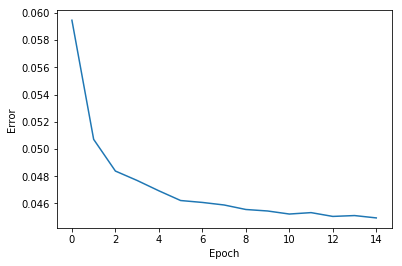

In [14]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        current_weight = sess.run(update_weight, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        current_vb = sess.run(update_vb, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        cur_nb = sess.run(update_hb, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        previous_weight = current_weight
        previous_vb = current_vb
        previous_hb = current_hb
    errors.append(sess.run(err_sum, feed_dict={visible_0: trX, W: current_weight, visibleBias: current_vb, hiddenBias: current_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

### Recommendation

We can now predict movies that an arbitrarily selected user might like. This can be accomplished by feeding in the user's watched movie preferences into the RBM and then reconstructing the input. The values that the RBM gives us will attempt to estimate the user's preferences for movies that he hasn't watched based on the preferences of the users that the RBM was trained on.

Lets first select a User ID of our mock user:

In [15]:
mock_user_id = 215

In [16]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [17]:
#Feeding in the user and reconstructing the input
hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
vv1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias)
feed = sess.run(hidden_0, feed_dict={ visible_0: inputUser, W: previous_weight, hiddenBias: previous_hb})
rec = sess.run(vv1, feed_dict={ hidden_0: feed, W: previous_weight, visibleBias: previous_vb})
print(rec)

[[0.5824928  0.24802381 0.07080343 ... 0.00350019 0.00244745 0.01251542]]


We can then list the 20 most recommended movies for our mock user by sorting it by their scores given by our model.

In [18]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.907937
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.787918
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.730321
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.703810
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.697067
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,0.654593
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.654497
1335,1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi,0.616564
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.596977
0,1,Toy Story (1995),Animation|Children's|Comedy,0.582493


So, how to recommend the movies that the user has not watched yet?

Now, we can find all the movies that our mock user has watched before:

In [19]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating,Timestamp
31603,215,3793,5,977099259
31604,215,1,4,979174987
31605,215,1197,5,976899663
31606,215,2302,5,976899718
31607,215,2167,5,976899770


In the next cell, we merge all the movies that our mock users has watched with the predicted scores based on his historical data:

In [21]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

Lets sort it and take a look at the first 20 rows:

In [22]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.907937,215.0,5.0,976899190.0
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.787918,NaN,NaN,NaN
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.730321,NaN,NaN,NaN
1449,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.703810,NaN,NaN,NaN
2426,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.697067,215.0,5.0,976908635.0
1108,1198,Raiders of the Lost Ark (1981),Action|Adventure,0.654593,NaN,NaN,NaN
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.654497,215.0,5.0,976899689.0
1258,1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi,0.616564,NaN,NaN,NaN
466,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.596977,215.0,5.0,976899784.0
0,1,Toy Story (1995),Animation|Children's|Comedy,0.582493,215.0,4.0,979174987.0


As you can see, there are some movies that user has not watched yet and has high score based on our model. So, we can recommend them to the user.

<a href='Dnn_model'></a>
# Simple Deep Neural Network Model

Simple Deep neural network model combining a collaborative filtering recommendation algorithm with deep learning technology, therein consisting of two parts. First, the model uses a feature representation method based on a quadric polynomial regression model,which obtains the latent features more accurately by improving upon the traditional matrix factorization algorithm. Then, these latent features are regarded as the input data of the deep neural network model, which is the second part of the proposed model and is used to predict the rating scores.

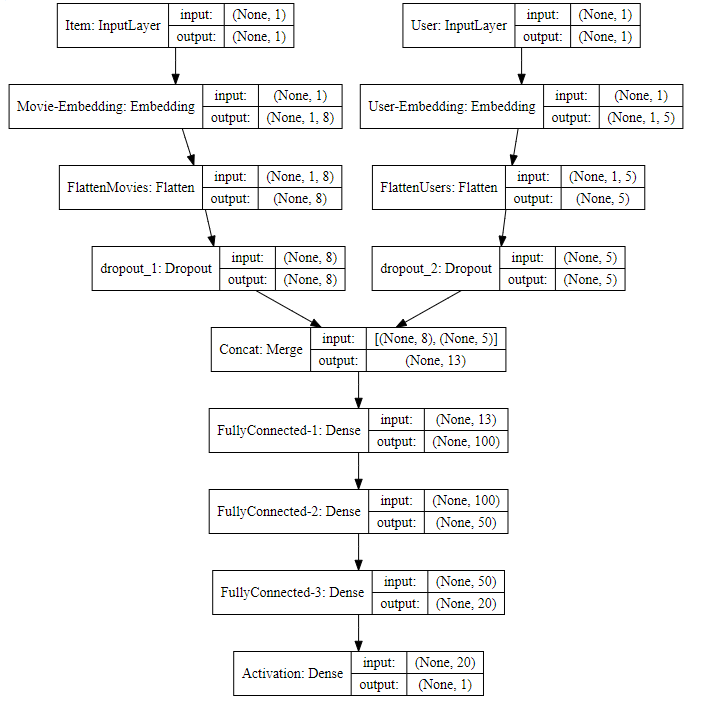

In [218]:
len(ratings_df.UserID.unique()), len(ratings_df.MovieID.unique())

(6040, 3706)

We assign a unique number between (0, #users) to each user and do the same for movies and create dataframe which have userid and movieid along with newly generated userid and movieid.

In [219]:
ratings_df['UserID_C'] = ratings_df.UserID.astype('category').cat.codes.values
ratings_df['MovieID_C'] = ratings_df.MovieID.astype('category').cat.codes.values
user_movie_cate_df = ratings_df[['UserID','UserID_C','MovieID','MovieID_C']]
ratings_df.drop(['UserID','MovieID'],axis=1,inplace=True)

In [220]:
ratings_df.head()

,Rating,Timestamp,UserID_C,MovieID_C
0,5,978300760,0,1104
1,3,978302109,0,639
2,3,978301968,0,853
3,4,978300275,0,3177
4,5,978824291,0,2162


#### Train test split

We'll now split our dataset of ratings into train and test. Given the train set, we'd like to accurately estimate the ratings in the test set.

In [221]:
train, test = train_test_split(ratings_df, test_size=0.2,random_state=7856)

# True rating for test dataframe
y_true = test.Rating

In [222]:
n_users, n_movies = len(ratings_df.UserID_C.unique()), len(ratings_df.MovieID_C.unique())
train.head()

,Rating,Timestamp,UserID_C,MovieID_C
251405,4,974772836,1518,858
784478,2,965532329,4681,1279
464897,1,972479172,2865,2275
1767,4,978160616,16,1741
266208,4,974740563,1612,1867


### Neural networks for recommendation

We'll now create a simple neural network for recommendation, or for estimating rating! This model is very similar to the matrix factorisation models, but differs in the following ways:

1. Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.

2. Due to #1, we can now have a different dimension of user and movie embeddings. This can be useful if one dimension is larger than the other.

In [226]:
n_latent_factors_user = 6
n_latent_factors_movie = 10

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([movie_vec, user_vec])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [227]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 10)        37070       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 6)         36246       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

We can see that the number of parameters is more than what we had in the Matrix Factorisation case. Let's see how this model works. I'll run it for more epochs given that we have more parameters.

In [228]:
history = model.fit([train.UserID_C, train.MovieID_C], train.Rating, epochs=30, verbose=0)

Prediction performance of Neural Network based recommender system

In [231]:
y_hat_2 = np.round(model.predict([test.UserID_C, test.MovieID_C]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.UserID_C, test.MovieID_C])))

0.6848961718039211
0.6995184199344089


In [233]:
test_user_215= pd.DataFrame({'UserID_C' : [214] * 3706,'MovieID_C':list(ratings_df['MovieID_C'].unique())})
#test_user_215.head()
test_user_215['Predicted_Ratings'] = np.round(model.predict([test_user_215.UserID_C, test_user_215.MovieID_C]),0)

In [234]:
test_user_215.head()

,UserID_C,MovieID_C,Predicted_Ratings
0,214,1104,5.0
1,214,639,4.0
2,214,853,5.0
3,214,3177,5.0
4,214,2162,5.0


In [235]:
result = pd.merge(test_user_215,test,how='left',on=['UserID_C','MovieID_C'])
result = result[pd.isnull(result['Rating'])]
result.sort_values(by='Predicted_Ratings',ascending=False,inplace=True)
result.head(10)

,UserID_C,MovieID_C,Predicted_Ratings,Rating,Timestamp
0,214,1104,5.0,NaN,NaN
1998,214,1931,5.0,NaN,NaN
1908,214,728,5.0,NaN,NaN
1907,214,1267,5.0,NaN,NaN
1906,214,1198,5.0,NaN,NaN
1903,214,2042,5.0,NaN,NaN
1902,214,1188,5.0,NaN,NaN
1895,214,1095,5.0,NaN,NaN
1892,214,557,5.0,NaN,NaN
1891,214,1089,5.0,NaN,NaN


In [244]:
result.rename(columns={'MovieID_C':'MovieID'},inplace=True)
final_df = pd.merge(result,movies_df,how='inner',on=['MovieID'])
final_df.sort_values(by=['Predicted_Ratings'],ascending=False).head(20)

,UserID_C,MovieID,Predicted_Ratings,Rating,Timestamp,Title,Genres
0,214,1104,5.0,NaN,NaN,"Streetcar Named Desire, A (1951)",Drama
978,214,1018,5.0,NaN,NaN,That Darn Cat! (1965),Children's|Comedy|Mystery
987,214,443,5.0,NaN,NaN,"Endless Summer 2, The (1994)",Documentary
986,214,3481,5.0,NaN,NaN,High Fidelity (2000),Comedy
985,214,339,5.0,NaN,NaN,While You Were Sleeping (1995),Comedy|Romance
984,214,2108,5.0,NaN,NaN,L.A. Story (1991),Comedy|Romance
983,214,2307,5.0,NaN,NaN,One Tough Cop (1998),Action|Drama
982,214,3246,5.0,NaN,NaN,Malcolm X (1992),Drama
981,214,882,5.0,NaN,NaN,"Trigger Effect, The (1996)",Drama|Thriller
980,214,170,5.0,NaN,NaN,Hackers (1995),Action|Crime|Thriller


<a id='enc_model'></a>
# Deep Autoencoder

![title](https://cdn-images-1.medium.com/max/1000/1*Uz3sGf9XyLyD5AfcUE9n3w.png)

An Autoencoder is a profound learning neural system design that accomplishes best in class execution in the territory of collaborative filtering and furthermore used to get familiar with a representation (encoding) for a lot of input data, usually to a achieve dimensionality reduction. Architecturally, the type of an Autoencoder is a feedforward neural system having an input layer, one hidden layer and a output layer.The output layer has the same number of neurons as the input layer for the purpose of reconstructing it’s own inputs. It is useful that an Autoencoder has a smaller hidden layer than the input layer. It is useful that an Autoencoder has a smaller hidden layer than the input layer. This effect forces the model to create a compressed representation of the data in the hidden layer by learning correlations in the data.The core purpose of the algorithm is to reconstruct the original input data.During the training time the encoder takes a input data sample x and maps it to the so called hidden or latent representation z. Then the decoder maps z to the output vector x’ which is (in the best case scenario) the exact representation of the input data x. Please notice that usually an exact recreation of the input x is not possible.The additional hidden layers enable the Autoencoder to learn mathematically more complex underlying patterns in the data.Deeper layers of the Deep Autoencoder tend to learn even higher-order features.

Autoencode takes inputs as user-item matrix where below code convert pivot table function to transform the ratings dataframe to user-movie matrix where value in the matrix is of ratings for user-movie pair.

In [75]:
# Lets pivot the data to get it at a user level
ratings_transform = pd.pivot_table(ratings_df[['UserID','MovieID','Rating']],values=['Rating'], index=['UserID'], columns=['MovieID'] ).fillna(0)

# creating train and test sets
X_train_enc, X_test_enc = train_test_split(ratings_transform, train_size=0.8,random_state=7856)

C:\Users\kahma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [76]:
X_train_enc.head()

Rating                                              ...             \
MovieID   0    1    2    3    4    5    6    7    8    9    ...  3696 3697   
UserID                                                      ...              
1289       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   1.0  0.0   
1456       4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   2.0  0.0   
5200       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
5951       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
5913       0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   

                                                 
MovieID 3698 3699 3700 3701 3702 3703 3704 3705  
UserID                                           
1289     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1456     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5200     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5951     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5913     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 3706 columns]

Below code initialize the weights and number of neurons for each layer in the autoencoder. we have generated weights for each layer using tf.random_normal which generates tensor of the specified shape with random normal values.

In [82]:
# Nodes for encoding layer
n_nodes_inpl = 3706  
n_nodes_hl1  = 1853  
n_nodes_hl2  = 925

# Nodes for hiddern layer
n_nodes_hl3  = 252  

# Nodes for decoding layer
n_nodes_hl4  = 925
n_nodes_hl5  = 1853
n_nodes_outl = 3706  

# input layer has 9724*4862 weights and 4862 biases
hidden_1_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_inpl,n_nodes_hl1]))}

# second encode layer has 4862*2431 weights and 2431 biases
hidden_2_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1,n_nodes_hl2]))}

# Third encode layer has 2431*512 weights and 512 biases
hidden_3_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl3]))}

# First decode layer has 512*2431 weights and 2431 biases
hidden_4_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3,n_nodes_hl4]))}

# Second decode layer has 2431*4862 weights and 4862 biases
hidden_5_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_hl4,n_nodes_hl5]))}

# output layer has 4862*9724 weights and 9724 biases
output_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_hl5,n_nodes_outl])) }

Built deep autoencode input, hidden and output layers using below code where one constant node has been created for each layer which represents bias for each layer having value equal to 1. Add bias to all neurons after multiplying the input layer and random normal weight and then apply activation function to add non linerity. This network has MSE a cost function and optimizing it using Adagrad optimizer.

In [108]:
# user with 3706 ratings goes in
input_layer = tf.placeholder('float', [None, 3706])

### First Layer
# add a constant node to the first layer
# it needs to have the same shape as the input layer for me to be
# able to concatinate it later
input_layer_const = tf.fill([tf.shape(input_layer)[0], 1] ,1.0 )
# multiply output of input_layer wth a weight matrix 
layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(input_layer,hidden_1_layer_vals['weights']),input_layer_const))

### Second Layer
input_layer_const1 = tf.fill( [tf.shape(layer_1)[0], 1] ,1.0  )
# multiply output of input_layer wth a weight matrix 
layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1,hidden_2_layer_vals['weights']),input_layer_const1))

### Third Layer
input_layer_const2 = tf.fill( [tf.shape(layer_2)[0], 1] ,1.0  )
# multiply output of input_layer wth a weight matrix 
layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2,hidden_3_layer_vals['weights']),input_layer_const2))

### Fourth Layer
input_layer_const3 = tf.fill( [tf.shape(layer_3)[0], 1] ,1.0  )
# multiply output of input_layer wth a weight matrix 
layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3,hidden_4_layer_vals['weights']),input_layer_const3))

### Fifth Layer
input_layer_const4 = tf.fill( [tf.shape(layer_4)[0], 1] ,1.0  )
# multiply output of input_layer wth a weight matrix 
layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4,hidden_5_layer_vals['weights']),input_layer_const4))

### Output Layer
# adding one bias node to the hidden layer
layer1_const = tf.fill( [tf.shape(layer_5)[0], 1] ,1.0  )s

# multiply output of hidden with a weight matrix to get final output
output_layer = tf.matmul(layer_5,output_layer_vals['weights'])

# output_true shall have the original shape for error calculations
output_true = tf.placeholder('float', [None, 3706])
# define our cost function
meansq =    tf.reduce_mean(tf.square(output_layer - output_true))
# define our optimizer
learn_rate = 0.001   # how fast the model should learn
optimizer = tf.train.AdagradOptimizer(learn_rate).minimize(meansq)

In [111]:
# initialising variables and starting the session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# defining batch size, number of epochs and learning rate
batch_size = 100  # how many users to use together for training
hm_epochs =100    # how many times to go through the entire dataset
tot_users = X_train_enc.shape[0] # total number of users

Train and test Deep Autoencoder with 100 epoch value and feed train and test data in order to get your reconstructed movie rating for that user. Also, calculate MSE for training and testing phase.

In [112]:
# running the model for a 100 epochs taking 100 users in batches
# total improvement is printed out after each epoch
for epoch in range(hm_epochs):
    epoch_loss = 0    # initializing error as 0
    
    for i in range(int(tot_users/batch_size)):
        epoch_x = X_train_enc[ i*batch_size : (i+1)*batch_size ]
        _, c = sess.run([optimizer, meansq],feed_dict={input_layer: epoch_x,output_true: epoch_x})
        epoch_loss += c
        
    output_train = sess.run(output_layer,feed_dict={input_layer:X_train_enc})
    output_test = sess.run(output_layer,feed_dict={input_layer:X_test_enc})
        
    print('MSE train', MSE(output_train, X_train_enc),'MSE test', MSE(output_test, X_test_enc))      
    print('Epoch', epoch, '/', hm_epochs, 'loss:',epoch_loss)

MSE train 717.8827531835316 MSE test 721.2971359886285
Epoch 0 / 100 loss: 39416.19738769531
MSE train 588.8045268721269 MSE test 592.9499724487845
Epoch 1 / 100 loss: 31350.027465820312
MSE train 499.1049062019719 MSE test 503.1666525128692
Epoch 2 / 100 loss: 26144.38507080078
MSE train 433.0062877090002 MSE test 437.11795716411353
Epoch 3 / 100 loss: 22409.0263671875
MSE train 382.2285363298209 MSE test 386.1151389161219
Epoch 4 / 100 loss: 19602.64239501953
MSE train 341.6850645136781 MSE test 345.16777591125276
Epoch 5 / 100 loss: 17407.228973388672
MSE train 308.386510255548 MSE test 311.55543854156986
Epoch 6 / 100 loss: 15630.277893066406
MSE train 280.5592578599356 MSE test 283.42160827273955
Epoch 7 / 100 loss: 14158.085723876953
MSE train 256.87845138032753 MSE test 259.55103518375944
Epoch 8 / 100 loss: 12918.815460205078
MSE train 236.33650461526895 MSE test 238.8395876776703
Epoch 9 / 100 loss: 11854.868789672852
MSE train 218.2814149517687 MSE test 220.6170982261209
Epoc

MSE train 4.585824306271618 MSE test 4.954951978464109
Epoch 87 / 100 loss: 224.15759706497192
MSE train 4.426347518676939 MSE test 4.7907340407381325
Epoch 88 / 100 loss: 216.32716608047485
MSE train 4.2737110303394275 MSE test 4.6334224306924305
Epoch 89 / 100 loss: 208.83389329910278
MSE train 4.127572257974294 MSE test 4.482673406304964
Epoch 90 / 100 loss: 201.66104221343994
MSE train 3.9876077109551247 MSE test 4.338157865360073
Epoch 91 / 100 loss: 194.79260087013245
MSE train 3.85351555161665 MSE test 4.199569477470893
Epoch 92 / 100 loss: 188.21350169181824
MSE train 3.7250092694417725 MSE test 4.066616359491388
Epoch 93 / 100 loss: 181.90957164764404
MSE train 3.6018157826015536 MSE test 3.9390243822225472
Epoch 94 / 100 loss: 175.86743450164795
MSE train 3.48367518503371 MSE test 3.81653812649429
Epoch 95 / 100 loss: 170.07418704032898
MSE train 3.3703354890993062 MSE test 3.6989138905919123
Epoch 96 / 100 loss: 164.51751589775085
MSE train 3.261569977008691 MSE test 3.58593

Select user with id 215 and get the reconstructed user ratings to compare the RBM model with deep autoencode and compare the recomendation for this user thorough both models. Display reconstructed movie ratings for 215 userid in reversed order to show highest ratings for this userid.


In [114]:
sample_user = X_test_enc.iloc[774,:]
sample_user_pred = sess.run(output_layer, feed_dict={input_layer:[sample_user]})

In [115]:
temp_list = sample_user_pred[0].tolist()
temp_list.sort(reverse=True)
print(temp_list)

[16.165756225585938, 15.988831520080566, 11.705475807189941, 10.658823013305664, 10.579139709472656, 10.395232200622559, 9.479464530944824, 9.397173881530762, 8.909300804138184, 8.69386100769043, 8.526571273803711, 8.379806518554688, 8.244812965393066, 8.205244064331055, 8.14462947845459, 7.983443260192871, 7.756653308868408, 7.701175212860107, 6.876827239990234, 6.710197448730469, 6.659328460693359, 6.65930700302124, 6.658473491668701, 6.622538089752197, 6.598176002502441, 6.597789287567139, 6.535475730895996, 6.454558849334717, 6.436232566833496, 6.423285007476807, 6.339150905609131, 6.167624473571777, 6.159274578094482, 6.141617774963379, 6.1415839195251465, 6.1383795738220215, 6.133572578430176, 6.021529674530029, 5.86934757232666, 5.864527702331543, 5.839612007141113, 5.8304924964904785, 5.723362922668457, 5.63017463684082, 5.602477550506592, 5.586070537567139, 5.546875953674316, 5.533117294311523, 5.403189659118652, 5.282736778259277, 5.266723155975342, 5.245149612426758, 5.19659

In [126]:
mock_user_id = 215


#Selecting the input user
inputUser = np.asarray(temp_list).reshape(1,-1)
inputUser[0:5]


#Feeding in the user and reconstructing the input
hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
vv1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias)
feed = sess.run(hidden_0, feed_dict={ visible_0: inputUser, W: previous_weight, hiddenBias: previous_hb})
rec = sess.run(vv1, feed_dict={ hidden_0: feed, W: previous_weight, visibleBias: previous_vb})
print(rec)


scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

[[0.49218085 0.1232059  0.09499651 ... 0.00334758 0.00365506 0.01687487]]


,MovieID,Title,Genres,RecommendationScore
1959,2028,Saving Private Ryan (1998),Action|Drama|War,0.781217
315,318,"Shawshank Redemption, The (1994)",Drama,0.776140
2693,2762,"Sixth Sense, The (1999)",Thriller,0.773159
352,356,Forrest Gump (1994),Comedy|Romance|War,0.750461
453,457,"Fugitive, The (1993)",Action|Thriller,0.714421
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,0.682390
523,527,Schindler's List (1993),Drama|War,0.639884
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.615010
1656,1704,Good Will Hunting (1997),Drama,0.601617
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.600536


In [127]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
1848,2028,Saving Private Ryan (1998),Action|Drama|War,0.781217,NaN,NaN,NaN
309,318,"Shawshank Redemption, The (1994)",Drama,0.776140,NaN,NaN,NaN
2557,2762,"Sixth Sense, The (1999)",Thriller,0.773159,NaN,NaN,NaN
346,356,Forrest Gump (1994),Comedy|Romance|War,0.750461,NaN,NaN,NaN
443,457,"Fugitive, The (1993)",Action|Thriller,0.714421,215.0,4.0,976863197.0
579,593,"Silence of the Lambs, The (1991)",Drama|Thriller,0.682390,215.0,4.0,976868548.0
513,527,Schindler's List (1993),Drama|War,0.639884,215.0,2.0,976868526.0
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.615010,NaN,NaN,NaN
1563,1704,Good Will Hunting (1997),Drama,0.601617,NaN,NaN,NaN
466,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.600536,NaN,NaN,NaN


# Model-Based Collberative Filtering
### Latent Semantic Model

Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

- The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
- When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
- You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

<a href='svd'></a>
# Singular Value Decomposition (SVD)
One of the well-known matrix factorization methods is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix $A$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:

Singular value decomposition is a method of decomposing a matrix into three other matrices:


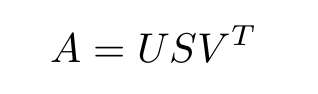






Where:

- A is an m × n matrix
- U is an m × r orthogonal matrix
- S is an r × r diagonal matrix
- V is an r × n orthogonal matrix

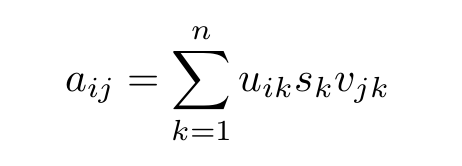

In [245]:
## Import Libraries
import os

from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from scipy.sparse.linalg import svds

from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate

from __future__ import (absolute_import, division, print_function,unicode_literals)

from surprise import SVDpp
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [247]:
## load data set
movies_df = pd.read_csv('../ml-1m/movies.dat', sep='::',names = ["movieId","title","genres"],header=None, engine='python')
users_df = pd.read_csv('../ml-1m/users.dat', sep='::',names = ["userId","gender","age","occupation","zip-code"],header=None, engine='python')
ratings_df = pd.read_csv('../ml-1m/ratings.dat', sep='::',names=["userId","movieId","rating","timestamp"],header=None, engine='python')

In [248]:
print("movies:",movies_df.shape)
print("users:",users_df.shape)
print("ratingss:",ratings_df.shape)

movies: (3883, 3)
users: (6040, 5)
ratingss: (1000209, 4)


#### Function to define moviesId those have not yet been predicted by the user

In [249]:
def User_Movie_notpred(UserId,df,rows):
    panda_df = pd.DataFrame(df)
    MoviesforUser = ((panda_df.loc[panda_df['userId'] == UserId])[['movieId']]).values.tolist()
    NotRecMovielist = ((panda_df[~panda_df['movieId'].isin(MoviesforUser)])[['movieId']])['movieId'].unique().tolist()
    return NotRecMovielist[:rows]

here randomly we have taken userId 215 for predicting the ratings for the movies those have not yet been rated by the user.
We restricted the movies Id to 50 rows for convenience.

In [251]:
User_Movie_notpred(215,ratings_df,15)

[1193,
 661,
 914,
 3408,
 2355,
 1287,
 2804,
 594,
 919,
 595,
 938,
 2398,
 2918,
 1035,
 2791]

We then set up various lookup tables that we will need to translate ratings into matrix elements and recommendations from the matrix factorization back to human readable form.

In [252]:
# Creating array to store movie id and title
movies_id2name, movies_name2id = {}, {}
ids = movies_df["movieId"].values
titles = movies_df["title"].values
for id, title in zip(ids, titles):
    movies_id2name[id] = title
    movies_name2id[title] = id
    
# Creating index for movieId
movies_id2idx, movies_idx2id = {}, {}
for idx, movie_id in enumerate(ratings_df["movieId"].unique()):
    movies_id2idx[movie_id] = idx
    movies_idx2id[idx] = movie_id
    
# Creating index for userId
users_id2idx, users_idx2id = {}, {}
for idx, user_id in enumerate(ratings_df["userId"].unique()):
    users_id2idx[user_id] = idx
    users_idx2id[idx] = user_id
    
# Calculate the lenth of the users and movies
num_users = len(users_id2idx)
num_movies = len(movies_id2idx)        

Finally, we are ready to construct the matrix. We choose to use a dense matrix full of zeros to start with, where rows represent users and columns represent movies. We have 6040 users and 3706 items, so our matrix R_val is of shape (6040, 3706). We use the lookup tables we just generated to fill out the ratings for each (user, movie) pair that we have information for.

In [253]:
def construct_original_matrix(num_users, num_movies, ratings_df,users_id2idx, movies_id2idx):
    X = np.zeros((num_users, num_movies), dtype=np.float32)
    for user_id, movie_id, rating in ratings_df[["userId", "movieId", "rating"]].values:
        X[users_id2idx[user_id], movies_id2idx[movie_id]] = rating
    return X

In [254]:
R_val = construct_original_matrix(num_users, num_movies, ratings_df,users_id2idx, movies_id2idx)

The next step is to compute different kinds of bias and remove it from the matrix. This allows SVD to be more effective, as we will see in the results later. Bias can be split up into global bg, user bu and user-item bui, which represent the bias across all users, bias per user and bias per item per user.

                                          b = bg + bu +bui
                                                    
Where
- b  = bias
- bg = global bias
- bu = user bias
- bui = bias per user per item

Since this is a sparse matrix, we will treat all zero entries as unknown, and only consider non-zero entries for computing the bias. This is done using the code below. As you can see, this is essentially computing and removing average values of all non-zero entries along different axes.

In [255]:
#Compute the bias 
def compute_bias(X, bias_type):
    Xc = X.copy()
    Xc[Xc == 0] = np.nan
    if bias_type == "global":
        return np.nanmean(Xc)
    elif bias_type == "user":
        return np.mean(np.nanmean(Xc, axis=0))
    elif bias_type == "item":
        return np.mean(np.nanmean(Xc, axis=1))
    else:
        raise Exception("invalid bias type")

In [256]:
#Remove the bias
def remove_bias(X, bias):
    Xc = X.copy()
    Xc[Xc == 0] = np.nan
    Xc = np.subtract(Xc, bias)
    Xc = np.nan_to_num(Xc)
    return Xc

In [257]:
#Compute and Remove the global bias across the users
bg = compute_bias(R_val, "global")
Rg_val = remove_bias(R_val, bg)

#Compute and remove the user bias
bu = compute_bias(Rg_val, "user")
Ru_val = remove_bias(Rg_val, bu)

#Compute and remove the item bias
bi = compute_bias(Rg_val, "item")
Ri_val = remove_bias(Rg_val, bi)

#Compute and remove the per item per user bias
bui = compute_bias(Ru_val, "item")
Rui_val = remove_bias(Ru_val, bui)

Now that we have our different debiased input matrices, the next step is to decompose it into its constituents using SVD, and recompose it to an approximation using smaller dimensions. This will give us a matrix whose reduced columns correspond to user-tastes rather than actual movies, so we can make predictions of how a user will rank the movies they haven't seen already, or rank movies according to how the user would like them. We use TF's built-in svd() call here.

The graph will factorize the input matrix R using SVD into matrices U, S and V, recompose reduced versions of the three matrices to get an approximation R'. It then computes the reconstruction error (MAE) between R and R', and also the proportion of explained variance R2 and returns it.

In [258]:
def reconstruct_using_svd(X, k):
    
    if k == 0:
        return X, 1., 0.
    
    graph = tf.Graph()
    with graph.as_default():
        
        # input arg
        R = tf.placeholder(tf.float32, shape=(num_users, num_movies), name="R")
        
        # run SVD
        S, U, Vt = tf.svd(R, full_matrices=True)
        
        # reduce dimensions
        Sk = tf.diag(S)[0:k, 0:k]
        Uk = U[:, 0:k]
        Vk = tf.transpose(Vt)[0:k, :]

        # reconstruct matrix
        Rprime = tf.matmul(Uk, tf.matmul(Sk, Vk))

        
        # compute reconstruction MAE
        rsquared = tf.linalg.norm(Rprime) / tf.linalg.norm(R)
        mae = tf.metrics.mean_absolute_error(R, Rprime)[1]
        
    with tf.Session(graph=graph) as sess:
        
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        
        [Rprime_val, rsquared_val, mae_val] = sess.run(
            [Rprime, rsquared, mae], feed_dict={R: X})
        return Rprime_val, rsquared_val, mae_val

Here we are calculating the reconstructed matrix with bias by using the above defined fuction and taking latent feature k = 50.

In [259]:
R_rec, rsquared, rec_err = reconstruct_using_svd(R_val, 50)

Instructions for updating:
Use tf.cast instead.


In [260]:
print("reconstruction error (MAE):", rec_err)
print("percentage of variance explained: {:.3f}".format(rsquared))
print("shape of reconstructed matrix: ", R_rec.shape)

reconstruction error (MAE): 0.21844204
percentage of variance explained: 0.704
shape of reconstructed matrix:  (6040, 3706)


We also create a method predict for predicting ratings that a user might give to a movie he hasn't seen yet, and a method recommend for recommending movies for a given user. Both methods take in a de-biased matrix and the bias to apply to the final results.

In [261]:
def predict(user_id, movie_ids, X_rec, bias, 
            users_id2idx, movies_id2idx, movies_id2name):
    predictions = []
    for movie_id in sorted(movie_ids):
        user_idx = users_id2idx[user_id]
        movie_idx = movies_id2idx[movie_id]
        movie_name = movies_id2name[movie_id]
        prediction = bias + X_rec[user_idx, movie_idx]
        predictions.append((user_id, movie_id, movie_name, prediction)) #append the prediction rate of the movies against the userId
    return predictions

In [262]:
def recommend(user_id, X_rec, top_n, bias, 
              users_id2idx, movies_idx2id, movies_id2name):
    user_idx = users_id2idx[user_id]
    rec_movies_idxs = np.argsort(-1 * X_rec[user_idx])[0:top_n] #recommendating top n movies
    recommendations = []
    for movie_idx in rec_movies_idxs:
        movie_id = movies_idx2id[movie_idx]
        movie_name = movies_id2name[movie_id]
        pred_rating = bias + X_rec[user_idx, movie_idx]
        recommendations.append((user_id, movie_id, movie_name, pred_rating)) # append all top n recommending movies against the userId
    return recommendations

Here by using SVD factorization method we are predicting the rating for userId 215 and on that basis top 10 movies are recommended to that userId.

In [264]:
R_rec, _, _ = reconstruct_using_svd(Rui_val, 10)
movie_ids = User_Movie_notpred(215,ratings_df,10)
preds = predict(215, movie_ids, R_rec, bg + bu + bui, users_id2idx, 
                movies_id2idx, movies_id2name) 
for pred in preds:
    print(pred)
print("---------------------------------------------------------------------")
R_rec, _, _ = reconstruct_using_svd(Ri_val, 10)
recs = recommend(215, R_rec, 10, bg + bi, users_id2idx, movies_idx2id, movies_id2name)
for rec in recs:
    print(rec)

(215, 594, 'Snow White and the Seven Dwarfs (1937)', 3.7326605)
(215, 595, 'Beauty and the Beast (1991)', 3.7849703)
(215, 661, 'James and the Giant Peach (1996)', 3.7088013)
(215, 914, 'My Fair Lady (1964)', 3.725639)
(215, 919, 'Wizard of Oz, The (1939)', 3.8021135)
(215, 1193, "One Flew Over the Cuckoo's Nest (1975)", 3.7281618)
(215, 1287, 'Ben-Hur (1959)', 3.77651)
(215, 2355, "Bug's Life, A (1998)", 3.7777786)
(215, 2804, 'Christmas Story, A (1983)', 3.8005369)
(215, 3408, 'Erin Brockovich (2000)', 3.7638147)
---------------------------------------------------------------------
(215, 260, 'Star Wars: Episode IV - A New Hope (1977)', 4.0347776)
(215, 1210, 'Star Wars: Episode VI - Return of the Jedi (1983)', 4.0347443)
(215, 1198, 'Raiders of the Lost Ark (1981)', 4.0149407)
(215, 480, 'Jurassic Park (1993)', 4.012251)
(215, 1196, 'Star Wars: Episode V - The Empire Strikes Back (1980)', 4.005173)
(215, 110, 'Braveheart (1995)', 3.9968603)
(215, 589, 'Terminator 2: Judgment Day (19

<a href='svd++'></a>
# SVD++ Algorithm

While SVD is able to provide very good recommendation quality, its ability to use only explicit numerical ratings as user-items interactions constitutes a limitation. Modern day recommender systems should exploit all available interactions both explicit (e.g. numerical ratings) and implicit (e.g. likes, purchases, skipped, bookmarked). To this end SVD++ was designed to take into account implicit interactions as well
SVD++ has however some disadvantages, with the main drawback being that this method is not model-based. This means that if a new user is added, the algorithm is incapable of modeling it unless the whole model is retrained. Even though the system might have gathered some interactions for that new user, it's latent factors are not available and therefore no recommendations can be computed. This is an example of a cold-start problem, that is the recommender cannot deal efficiently with new users or items and specific strategies should be put in place to handle this disadvantage.

In [281]:
# Use movielens 1m dataset from Dataset package
from surprise import Dataset
data = Dataset.load_builtin('ml-1m')
type(data)

Dataset ml-1m could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to C:\Users\Akshay/.surprise_data/ml-1m


surprise.dataset.DatasetAutoFolds

In [282]:
# Split train and test dataset
trainset, testset = train_test_split(data, test_size=.15)

In [283]:
svdpp = SVDpp(n_factors=20, n_epochs=20, lr_all=0.007, reg_all=0.02)
svdpp.fit(trainset)
test_pred = svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.mae(test_pred, verbose=True)

SVDpp : Test Set
MAE:  0.6697


0.669701548790149

We have explored and used Surprise package: This package has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of CF algorithms.

<a href='hybrid'></a>
# Hybrid Model (Content Based Filtering + SVD)

Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document. The user profile is represented with the same terms and built up by analyzing the content of items which have been seen by the user.

The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.
We will consider genres as an important parameter to recommend user the movie he watches based on generes of movie user has already watched.

For calculating distances, many similarity coefficients can be calculated. Most widely used similarity coefficients are Euclidean, Cosine, Pearson Correlation etc.

#### Cosine similarity 
Well cosine similarity is a measure of similarity between two non zero vectors. Cosine similarity finds how two vectors are related to each other using measuring cosine angle between these vectors.

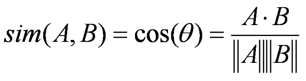

We will use cosine distance here. Here we are insterested in similarity. That means higher the value more similar they are. But as the function gives us the distance, we will deduct it from 1.

In [267]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
movies_df['genres'] = movies_df['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies_df['genres'])
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)

Here a function is defined to calculate the top 2 movies to recommend based on given movie title genres.
cosine_sim_movies = the cosine similarities between movies
We are returning the title of the movie as recommendation.

In [268]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    
    # Get the index of the movie that matches the title
    idx_movie = movies_df.loc[movies_df['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return movies_df['title'].iloc[movie_indices]

In [269]:
get_recommendations_based_on_genres("Friday (1995)")

18    Ace Ventura: When Nature Calls (1995)
37                      It Takes Two (1995)
Name: title, dtype: object

Define a function to calculate top movies to be recommended to the user based on the movie user has wateched.

In [270]:
def get_recommendation_content_model(userId):
    
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = ratings_df[ratings_df["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((movies_df["title"][row["movieId"]==movies_df["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

{'Ace Ventura: When Nature Calls (1995)',
 'Aladdin and the King of Thieves (1996)',
 'Amateur (1994)',
 'American Tail, An (1986)',
 'American in Paris, An (1951)',
 'Assassins (1995)',
 'Beauty and the Beast (1991)',
 'Bedknobs and Broomsticks (1971)',
 'Beetlejuice (1988)',
 'Beyond Rangoon (1995)',
 'Bogus (1996)',
 'Carrington (1995)',
 'Coneheads (1993)',
 'Dark Crystal, The (1982)',
 'Emerald Forest, The (1985)',
 'Faust (1994)',
 'Full Metal Jacket (1987)',
 'Gumby: The Movie (1995)',
 'Heaven & Earth (1993)',
 'I Married A Strange Person (1997)',
 'Inspector General, The (1949)',
 'It Takes Two (1995)',
 'Jack and Sarah (1995)',
 'Jewel of the Nile, The (1985)',
 'Jungle Book, The (1967)',
 'Karate Kid, Part II, The (1986)',
 'Kicking and Screaming (1995)',
 'Kiss of Death (1995)',
 'Lady and the Tramp (1955)',
 'Leaving Las Vegas (1995)',
 'Little Mermaid, The (1989)',
 'Little Princess, A (1995)',
 "Midsummer Night's Dream, A (1999)",
 'Modern Affair, A (1995)',
 'Muppet Chr

## Hybrid Model

A hybrid approach, combining collaborative filtering and content-based filtering could be more effective in some cases. Hybrid approaches can be implemented in several ways: by making content-based and collaborative-based predictions separately and then combining them; by adding content-based capabilities to a collaborative-based approach (and vice versa); or by unifying the approaches into one model

In [284]:
svd = SVD()

In [287]:
trainset = data.build_full_trainset()
svd.train(trainset)

C:\Users\Akshay\PycharmProjects\Big_Data_Class\venv\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [288]:
#movie=movies_df
#rating=ratings_df
def hybrid_content_svd_model(userId):
    """
    hydrid the functionality of content based and svd based model to recommend user top 10 movies. 
    :param userId: userId of user
    :return: list of movies recommended with rating given by svd model
    """
    recommended_movies_by_content_model = get_recommendation_content_model(userId)
    recommended_movies_by_content_model = movies_df[movies_df.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    for key, columns in recommended_movies_by_content_model.iterrows():
        predict = svd.predict(userId, columns["movieId"])
        recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
        
    return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]

In [289]:
recommended_movies_by_content_model = get_recommendation_content_model(215)
hybrid_content_svd_model(215)

C:\Users\Akshay\PycharmProjects\Big_Data_Class\venv\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Akshay\PycharmProjects\Big_Data_Class\venv\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,movieId,title,genres,svd_rating
18,19,Ace Ventura: When Nature Calls (1995),Comedy,3.581564
1254,1274,Akira (1988),Adventure|Animation|Sci-Fi|Thriller,3.581564
1057,1071,For the Moment (1994),Romance|War,3.581564
1084,1100,Days of Thunder (1990),Action|Romance,3.581564
1111,1127,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,3.581564
1113,1129,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,3.581564
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,3.581564
1181,1199,Brazil (1985),Sci-Fi,3.581564
1188,1206,"Clockwork Orange, A (1971)",Sci-Fi,3.581564
1233,1253,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi,3.581564


<a href='conc'></a>
# Conclusion

With deep learning algorithms used in this notebook, We have implemented Restricted Boltzmann Machine, Deep Autoencoder, and simple deep neural network for this project to analyze movielens dataset. The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the number of movies in our dataset. Taking hiddenUnits = 20, error_function = MAE, epochs = 15 and activation function = {tf.sigmoid and tf.relu }, the model showed MAE of 0.0449. Deep Autoencoder algorithms used to predict the rating for user who has not rated movies. Deep Autoencoder algorithm predicted movie ratings with epochs=100, batch size= 100 and MAE as 3.37 for test and 3.05 for train phase. Simple deep neural network takes user and movies as separate matrix and create embeddings on both matrices after that feature creation has done by taking dot product of the user and the item embeddings to feed in the network. Network has trained to predict the user rating for movie with MAE 0.69. Using traditional algorithms, We attempted to build a model-based Collaborative Filtering movie recommendation system based on latent features from a low rank matrix factorization method called SVD and SVD++.For SVD model we get an MAE of 0.218 with bias and 0.064 without bias and for SVD++ model we get an MAE of 0.744. After analyzing results from implemented model, We have found that Restricted Boltzmann Machine model performed better than other models due to the restriction over the structure of Boltzmann Machine.

Also, User-based Collaborative Filtering gives recommendations that can be complements to the item the user was interacting with. This might be a stronger recommendation than what a item-based recommender can provide as users might not be looking for direct substitutes to a movie they had just viewed or previously watched.

In [149]:
header_Cl = ["Model" , "Mean Absoulte Error"]
table_cl  = [
        ["RBM",'0.0449'],
        ["Autoencoders",'3.37'],
        ["SVD",'0.218 with bias and 0.064 without bias'],
        ["SVD++",'0.744'],
        ["DNN with Keras",'0.69'],
            ]
print(tabulate(table_cl, header_Cl, tablefmt="fancy_grid"))

╒════════════════╤════════════════════════════════════════╕
│ Model          │ Mean Absoulte Error                    │
╞════════════════╪════════════════════════════════════════╡
│ RBM            │ 0.0449                                 │
├────────────────┼────────────────────────────────────────┤
│ Autoencoders   │ 3.37                                   │
├────────────────┼────────────────────────────────────────┤
│ SVD            │ 0.218 with bias and 0.064 without bias │
├────────────────┼────────────────────────────────────────┤
│ SVD++          │ 0.744                                  │
├────────────────┼────────────────────────────────────────┤
│ DNN with Keras │ 0.69                                   │
╘════════════════╧════════════════════════════════════════╛


# Contribution Statement

### For Deep Learning Algorithms:
We implemented Restricted Boltzmann Machine, which is a two-layer undirected graphical model. We also demonstrated that RBM’s can give better result than other traditional models when applied to a large dataset containing over 1 million user/movie ratings. We have analyzed the RBM model performance by carefully tuning learning rates, batch sizes, epochs and weight-decay.

We have implemented simple deep learning model with user and item embedding and merging both matrices to use them as features which can learn complex non-linear relationship. The Model implementation has done in keras with layer which creates user and movie embedding matrices, merging the flatten matrices for user and movies embedding matrices and feed into neural network to treat them as features to predict the ratings. Simple DNN model trained on 80% of the ratings data with 10 latent feature for movie and 6 latent features for user along with epoch value=30.

In Deep Autoencoder algorithm, we have tried to tune the network archietecture by changing the number of layes, number of epoch values, step size value, changing the activation function, adding or removing dense layer and compression or decompression rate for input data. By experimentning all combination, our final implementation of deep autoencoder is with 3 layer of compression , 3 layers of decompression, 30 epochs, sigmoid activation function and random normal weight matrix which multiple with input of individual layer and adding bias to it.

### For Tranditional Algorithms:
•	To know more about the model performance, we have used Mean Absolute error as an evaluating score.

•	To avoid redundancy cookie cutters are used thought out the algorithms.

•	Instead of doing matrix factorization by using inbuild SVD libraries, we have calculated svd algorithm by using tensor flow libraries.

•	We have also computed the biases globally, per user, per item and per item per user. Then the models were evaluated by removing the biases.

•	To get a better matrix representation of the data frames, we have used various lookup tables and introduced indexes to the corresponding movie-Id and user-Id. 

•   Then to evaluate the model performance and reduce the error we have implemented the extended version of svd, i.e. svd++, which takes into account the implicit interaction between user-item.

•	For SVD++ we have used surprise library along with hybrid model for recommendation system has been implemented as a part of traditional recommendation system and compare with the deep recommendation system to know the model performances.

<a href='scope'></a>
# Scope

The domain of the research covered most our prominent recommender models used in the industry currently. This research project focuses on performance analysis of various recommender system algorithms when dealing with very large sparse dataset (Movielens-1m). Analysis is carried out on various deep learning (such as Autoencoders, Restricted Boltzmann Machines, Deep Neural Networks) and traditional recommender system models (such as SVD’s, SVD++ and Hybrid) to determine how do each individual model performs when fed with large sparse dataset.
We analyzed each recommender system architecture in depth and then carefully tuned each one of them individually to determine how their performance vary with loss function, batch size, number of epochs, linear and non-linear activation functions. The study also included matrix factorization, contrastive divergence, WALS method for matrix factorization using TensorFlow and rating based on recommendation score when evaluating model performance.
Implemented techniques to overcome challenges related to recommender systems like Sparsity, Scalability, Latency problems, Cold start problems.


<a href='cita'></a>
# Citation

* https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8668497

* https://towardsdatascience.com/deep-autoencoders-for-collaborative-filtering-6cf8d25bbf1d

* https://arxiv.org/pdf/1708.01715.pdf

* https://medium.com/@connectwithghosh/recommender-system-on-the-movielens-using-an-autoencoder-using-tensorflow-in-python-f13d3e8d600d

* https://pdfs.semanticscholar.org/edca/6b95d76f9ec1c93ac6f334cb8153d5ebaf83.pdf

*  https://courses.cognitiveclass.ai/courses/course-v1:CognitiveClass+ML0120ENv2+2018/courseware/76d637cbe8024e509dc445df847e6c3a/d2529e01786a412fb009daef4b002a48/

* https://medium.com/@tanaykarmarkar/explainable-restricted-boltzmann-machine-for-collaborative-filtering-6f011035352d

* https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf

* https://chronicles.mfglabs.com/rbm-and-recommender-systems-3fa30f53d1dc

* https://adityashrm21.github.io/Book-Recommender-System-RBM/

* https://towardsdatascience.com/creating-a-hybrid-content-collaborative-movie-recommender-using-deep-learning-cc8b431618af
* https://www.quora.com/Whats-the-difference-between-SVD-and-SVD++
* https://en.wikipedia.org/wiki/Singular_value_decomposition
* https://ieeexplore.ieee.org/Xplore/cookiedetectresponse.jsp
* https://towardsdatascience.com/creating-a-hybrid-content-collaborative-movie-recommender-using-deep-learning-cc8b431618af
* https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/lehre/SS2011/Collaborative_Filtering/pres1-matrixfactorization.pdf
* https://grouplens.org/datasets/movielens/1m/

<a href='lic'></a>
# Licence

MIT License

Copyright (c) 2019 Akshay Patel, Kamran Ahmed, Pratyusha Kar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.